In [3]:
from numpy.matrixlib.defmatrix import matrix
from utils import *
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import matplotlib.pyplot as plt
import cv2

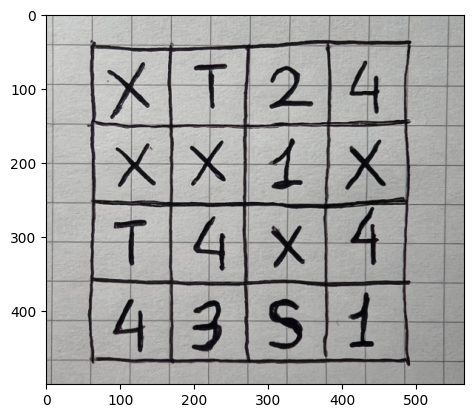

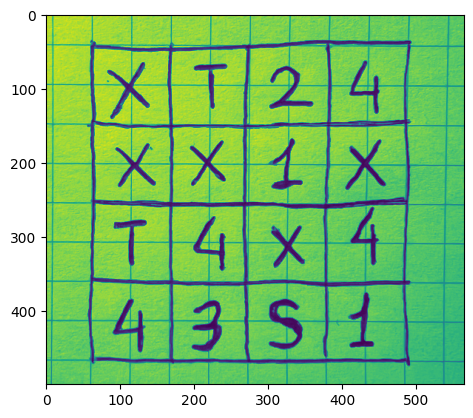

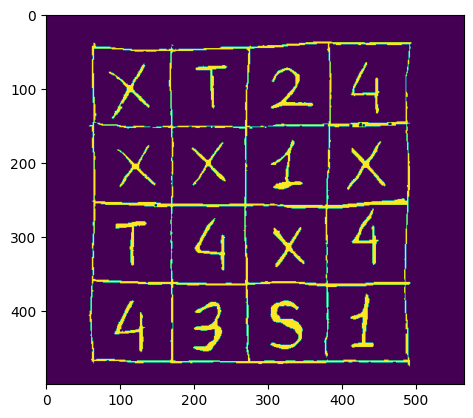

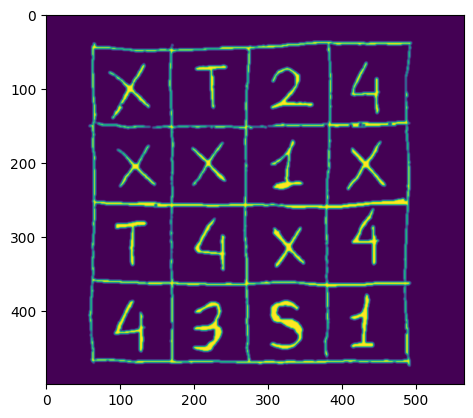

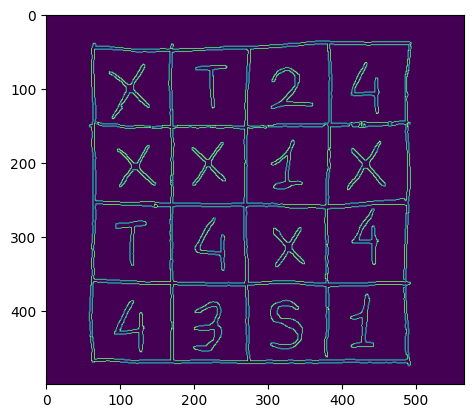

In [22]:
pathImage = "./img/maze_hand.jpg"
#pathImage = "./img/maze_5.jpg"
# load the example image
image = cv2.imread(pathImage)
imgBlank = np.zeros((500, 500, 3), np.uint8)  # blank for debugging
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
erode_kernel = np.ones((2, 2), np.uint8)
thresh = cv2.erode(thresh, erode_kernel, thresh, iterations=2)
blurred = cv2.GaussianBlur(thresh, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)


plt.imshow(image)
plt.show()
plt.imshow(gray)
plt.show()
plt.imshow(thresh)
plt.show()
plt.imshow(blurred)
plt.show()
plt.imshow(edged)
plt.show()

In [24]:
# find contours in the edge map, then sort them by their
# size in descending order
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if the contour has four vertices, then we have found
    # the thermostat display
    if len(approx) == 4:
        displayCnt = approx
        break


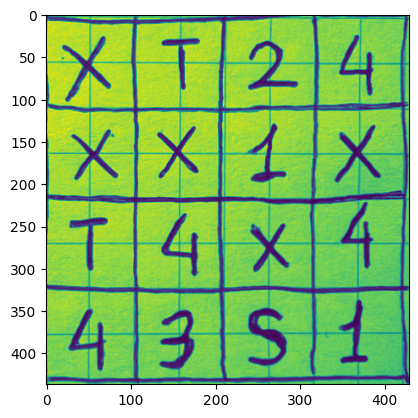

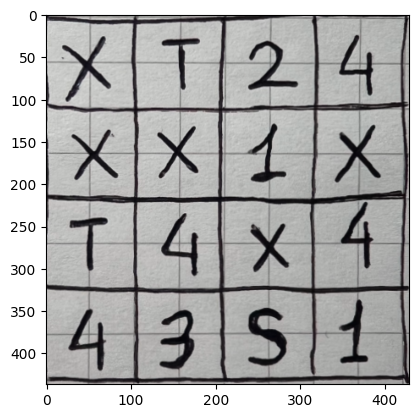

In [25]:
# extract the thermostat display, apply a perspective transform
# to it
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))

plt.imshow(warped)
plt.show()
plt.imshow(output)
plt.show()


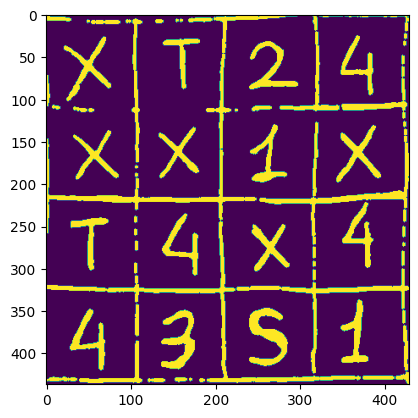

In [28]:
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

plt.imshow(thresh)
plt.show()

In [31]:
def inside(r1, r2):
    x1, y1, w1, h1 = r1
    x2, y2, w2, h2 = r2
    return (x1 > x2) and (y1 > y2) and (x1 + w1 < x2 + w2) and (y1 + h1 < y2 + h2)


def wrap_digit(rect, img_w, img_h):
    x, y, w, h = rect
    x_center = x + w // 2
    y_center = y + h // 2
    if h > w:
        w = h
        x = x_center - (w // 2)
    else:
        h = w
        y = y_center - (h // 2)

    padding = 5
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding

    if x < 0:
        x = 0
    elif x > img_w:
        x = img_w

    if y < 0:
        y = 0
    elif y > img_h:
        y = img_h

    if x + w > img_w:
        w = img_w - x

    if y + h > img_h:
        h = img_h - y

    return x, y, w, h


In [32]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def sortBoundingBox(rectangles): 
    _,temp,_,_ = rectangles[0]
    tempArr=[]
    outArr=[]
    for r in rectangles:
        x,y,_,_ = r
        if y < temp-5 or y > temp + 5:
            tempArr.sort(key=lambda y: y[0])
            outArr.insert(0,tempArr.copy())
            tempArr.clear()
        tempArr.append(r)
        temp = y
        
    tempArr.sort(key=lambda y: y[0])
    outArr.insert(0,tempArr.copy())
    tempArr.clear()
    """for r in outArr:
        tempArr.append(r)"""
    return flatten(outArr)

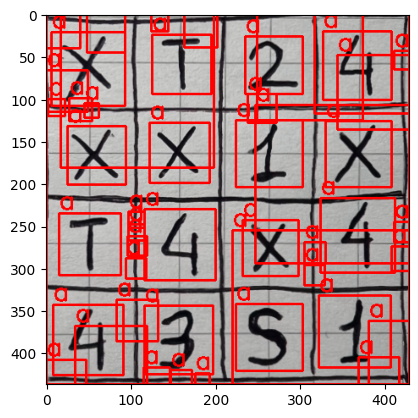

In [34]:
rectangles = []
contours, hier = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_h, img_w = output.shape[:2]
img_area = img_w * img_h
for c in contours:
    a = cv2.contourArea(c)
    if a >= 0.98 * img_area or a <= 0.0001 * img_area:
        continue

    r = cv2.boundingRect(c)
    is_inside = False
    for q in rectangles:
        if inside(r, q):
            is_inside = True
            break
    if not is_inside:
        rectangles.append(r)
count = 0
rectangles = sortBoundingBox(rectangles)
for r in rectangles:
    count += 1
    x, y, w, h = wrap_digit(r, img_w, img_h)
    roi = thresh[y : y + h, x : x + w]
    
#     predictions = model.predict(roi)
#     classIndex = np.argmax(predictions, axis=-1)
    
    cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(
        output, "a", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2
    )

plt.imshow(output)
plt.show()

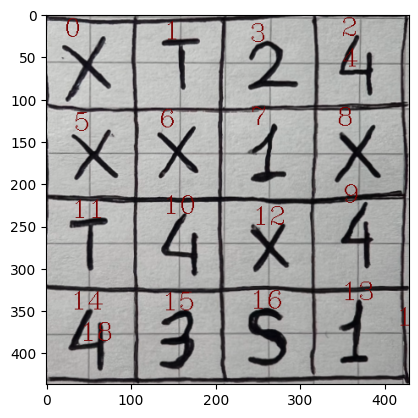

In [30]:
# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # if the contour is sufficiently large, it must be a digit
    if w >= 15 and (h >= 30 and h <= 100):
        digitCnts.append(c)

boxes = output.copy()

def get_contour_precedence(contour, cols):
    tolerance_factor = 10
    origin = cv2.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]


digitCnts.sort(key=lambda x: get_contour_precedence(x, boxes.shape[1]))

# For debugging purposes.
for i in range(len(digitCnts)):
    boxes = cv2.putText(
        boxes,
        str(i),
        cv2.boundingRect(digitCnts[i])[:2],
        cv2.FONT_HERSHEY_COMPLEX,
        1,
        [125],
    )

plt.imshow(boxes)
plt.show()